#                                  Udacity Self Driving Nano Degree     

##                                                   Term 1- Project 1



In [1]:
# Import required functons and libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import math

## Helper Functions

In [2]:

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    

def hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    
    return masked_image    


## Line Function, Added Line Equation and Extrapolation Method

In [3]:
def draw_lines(img, lines,color=[255,0,0],thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #Define Global parameters which will be later used in the function to collect points from hough transform
    
    left_x=[]
    left_y=[]
    right_x=[]
    right_y=[]
    
    global x0_left
    global x2_left
    global y2_left
    global x0_right
    global y2_r
    global x2_r
    
    y1_int=img.shape[0]
    y2_int=img.shape[1]
    
    x0_float=[]
    x0_float_r=[]
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope=(y2-y1)/(x2-x1)
            if x2==x1:
                continue
                
            # Negative Slope
            
            elif slope<0:
                left_x += [x1,x2]
                left_y += [y1,y2]
                m_left=np.polyfit(left_x,left_y,1)
                left_line=np.poly1d(m_left)
                left_data=left_line(left_x)
                y2_left=int(min(left_data))
                y1_left=int(max(left_data))
                x1_left=int(min(left_x))
                x2_left=int(max(left_x))
                x0=(y1_int-m_left[1])/m_left[0]
                x0_float +=[x0]
                x0_left=int(min(x0_float))
                
            #Positive Slope
            
            elif slope>0:
                right_x += [x1,x2]
                right_y += [y1,y2]
                m_right=np.polyfit(right_x,right_y,1)
                right_line=np.poly1d(m_right)
                right_data=right_line(right_x)
                y2_r=int(min(right_data))
                y1_r=int(max(right_data))
                x2_r=int(min(right_x))
                x1_r=int(max(right_x))
                x0_r=(y1_int-m_right[1])/m_right[0]
                x0_float_r +=[x0_r]
                x0_right=int(min(x0_float_r))
                
    left_lane= cv2.line(img,(x0_left,y1_int),(x2_left,y2_left),color,thickness)
    right_lane= cv2.line(img,(x0_right,y1_int),(x2_r,y2_r),color,thickness)
    

## Hough Transform

In [4]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    #samples=np.array(lines)
    #list_new=samples.tolist()
    
    #print(list_new)
    #print(lines.tolist())
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


# Image Analysis (Pipeline 1)

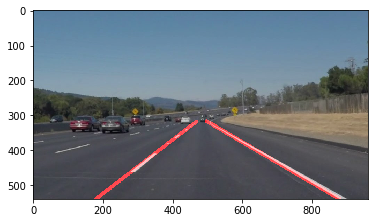

solidWhiteCurve.jpg


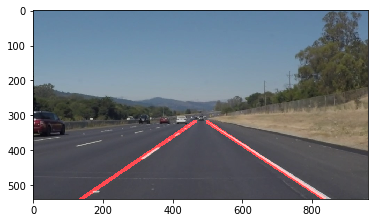

solidWhiteRight.jpg


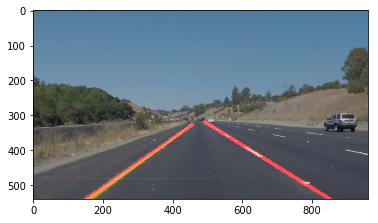

solidYellowCurve.jpg


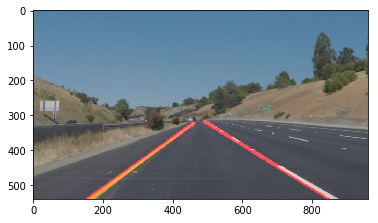

solidYellowCurve2.jpg


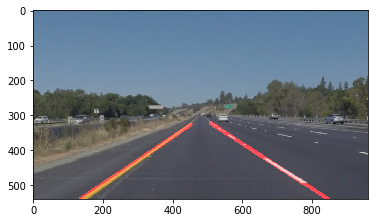

solidYellowLeft.jpg


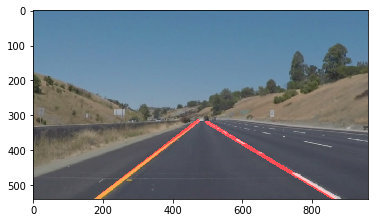

whiteCarLaneSwitch.jpg


In [5]:
#Read sample images and create lines
#No need to HSV filter as its the lines can be drawn using basic functions itself

import os
os.listdir("test_images/")
#Pipe Line
for i in os.listdir('test_images/'):
    if i[0:6] != "output":
        img=mpimg.imread('test_images/'+i)
        imshape=img.shape
        gray=grayscale(img)
        blur=gaussian_blur(gray,3)
        edges=canny(blur,50,150)
        vertices = np.array([[(100,imshape[0]),(450, 320), (510, 320), (930,imshape[0])]], dtype=np.int32)
        roi=region_of_interest(edges,vertices)
        htform=hough_lines(roi,1,np.pi/180,20,120,300)
        final=weighted_img(htform,img,α=0.8, β=1.1, γ=0.1)
        result=final
        plt.imshow(result,cmap='gray')
        plt.imsave('results/'+i,result)
    plt.show()
    print(i)


In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Video Analysis (Pipeline 2)

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    imshape=image.shape
    
    #Gray Filter
    gray=grayscale(image)
    
    #HSV Filter
    hsv_image=hsv(image)
   
    #Color Boundaries
    lower_yel = np.array([20,100,100])
    upper_yel = np.array([30,255,255])
    lower_wht = np.array([0,0,235])
    upper_wht = np.array([255,255,255])

    # Appply Mask to HSV Output with Color Boundaries
    mask1 = cv2.inRange(hsv_image, lower_yel, upper_yel)
    mask2 = cv2.inRange(hsv_image, lower_wht, upper_wht)

    # Apply Bitwise - OR Function to join both masks
    res = cv2.bitwise_or(mask1,mask2)# mask= mask)
    
    #Modify Gray Filter Output & Bitwise OR Function
    subdued_gray = (gray / 2).astype('uint8')
    boosted_lanes = cv2.bitwise_or(subdued_gray, res)
    
    #Rest of the pipeline is same as other pipelines
    blur=gaussian_blur(boosted_lanes,5)
    edges=canny(blur,50,100)
    vertices = np.array([[(100,imshape[0]),(450, 320), (510, 320), (930,imshape[0])]], dtype=np.int32)
    roi=region_of_interest(edges,vertices)
    htform=hough_lines(roi,1,np.pi/180,70,70,250)
    final=weighted_img(htform,image,α=0.8, β=1.1, γ=0.1)
    result=final
    return result

## Solid White Lines, Right

In [8]:
white_output = 'results/solidWhiteRight_mod.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video results/solidWhiteRight_mod.mp4
[MoviePy] Writing video results/solidWhiteRight_mod.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:07<00:00, 31.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results/solidWhiteRight_mod.mp4 

Wall time: 7.47 s


## Display the Output Video Video

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Solid Yellow, Left

In [10]:
yellow_output = 'results/solidYellowLeft_mod.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video results/solidYellowLeft_mod.mp4
[MoviePy] Writing video results/solidYellowLeft_mod.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:17<00:00, 38.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results/solidYellowLeft_mod.mp4 

Wall time: 18.2 s


## Display Output Video

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

# Video Analysis (Pipeline 3)
## Same as Pipeline 2, but tuned some parameters and modified vertices to change ROI 

In [12]:
def process_image_new(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    imshape=image.shape
    
    #Gray Filter
    gray=grayscale(image)
    
    #HSV Filter
    hsv_image=hsv(image)
   
    #Color Boundaries
    lower_yel = np.array([20,100,100])
    upper_yel = np.array([30,255,255])
    lower_wht = np.array([0,0,235])
    upper_wht = np.array([255,255,255])

    # Appply Mask to HSV Output with Color Boundaries
    mask1 = cv2.inRange(hsv_image, lower_yel, upper_yel)
    mask2 = cv2.inRange(hsv_image, lower_wht, upper_wht)

    # Apply Bitwise - OR Function to join both masks
    res = cv2.bitwise_or(mask1,mask2)# mask= mask)
    
    #Modify Gray Filter Output & Bitwise OR Function
    subdued_gray = (gray / 2).astype('uint8')
    boosted_lanes = cv2.bitwise_or(subdued_gray, res)
    
    #Gaussian Blur and Edge Detection
    blur=gaussian_blur(boosted_lanes,5)
    edges=canny(blur,150,300)
    
    #Modified Vertices to fit ROI
    vertices = np.array([[(imshape[1]*0.1,imshape[0]*0.9),(imshape[1]*0.48, imshape[0]*0.60), (imshape[1]*0.55, imshape[0]*0.60), (imshape[1],imshape[0]*0.9)]], dtype=np.int32)
    roi=region_of_interest(edges,vertices)
    
    #Hough Transform
    htform=hough_lines(roi,1,np.pi/180,20,20,150)
    final=weighted_img(htform,image,α=0.8, β=1.1, γ=0.1)
    result=final
    return result



## Challenge Video

In [13]:
challenge_output = 'results/challenge_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image_new)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video results/challenge_output.mp4
[MoviePy] Writing video results/challenge_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:11<00:00, 21.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results/challenge_output.mp4 

Wall time: 12.3 s


## Display Output Video

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))